# **0. Library & Data Imports**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, learning_curve 

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore
from tensorflow.keras import layers, Model , regularizers # type: ignore

from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings("ignore")


In [5]:
df = pd.read_csv('data/data_bersih.csv')
df.head()

,sentimen,tweet,_exclaim,_question,_upper_rt,tweet_pp
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...,1,2,0.030769,prabowo indonesia tidak dihargai bangsa asing ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",0,1,0.139785,batuan langka hadiah habib luthfi seharga mercy ?
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik....",0,0,0.103175,era indonesia baik indonesiamaju jokowilagi
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p...",1,0,0.054688,sumatera selatan asian games berdampak percaya...
4,negatif,Negara kita ngutang buat bngun infrastruktur y...,0,0,0.008197,negara ngutang bingung infrastruktur dipakai m...


In [ ]:
text_col, target_col = "tweet_pp", "sentimen"
X_all = df[text_col].astype(str).values
le = LabelEncoder()
y_all = le.fit_transform(df[target_col].astype(str).values)

# Train/Test (15%), lalu Train/Val (15% dari train)
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.15, random_state=16, stratify=y_all
)
X_tr_text, X_val_text, y_tr, y_val = train_test_split(
    X_train_text, y_train, test_size=0.15, random_state=7, stratify=y_train
)

# cek
print(X_tr_text.shape,X_val_text.shape, X_test_text.shape)

# **BiLSTM + Regularization**

In [103]:
tok = Tokenizer(num_words=MAX_WORDS, oov_token="<oov>")
tok.fit_on_texts(X_tr)

Xtr_pad = pad_sequences(tok.texts_to_sequences(X_tr),  maxlen=MAX_LEN, padding="post", truncating="post")
Xval_pad = pad_sequences(tok.texts_to_sequences(X_val), maxlen=MAX_LEN, padding="post", truncating="post")
Xte_pad  = pad_sequences(tok.texts_to_sequences(X_test),maxlen=MAX_LEN, padding="post", truncating="post")
vocab_size = min(MAX_WORDS, len(tok.word_index)+1)

Xtr_pad.shape, Xval_pad.shape, Xte_pad.shape, vocab_size, list(le.classes_)

((1234, 48), (218, 48), (363, 48), 5181, ['negatif', 'netral', 'positif'])

In [109]:
EMB_DIM    = 64
BILSTM_U   = 32        
DROPOUT_H  = 0.50
L2_W       = 1e-4      
LR         = 8e-4

tf.random.set_seed(42)

inp = layers.Input(shape=(MAX_LEN,), dtype="int32")

# Embedding kecil + L2
emb = layers.Embedding(
    input_dim=vocab_size, output_dim=EMB_DIM,
    embeddings_regularizer=regularizers.l2(L2_W)
)(inp)
x = layers.SpatialDropout1D(0.40)(emb)

# BiLSTM dengan return_sequences=True untuk attention
seq = layers.Bidirectional(
    layers.LSTM(
        BILSTM_U, return_sequences=True,
        dropout=0.30, recurrent_dropout=0.30,
        kernel_regularizer=regularizers.l2(L2_W),
        recurrent_regularizer=regularizers.l2(L2_W)
    )
)(x)  

# ----- Attention sederhana dengan masking padding -----
score = layers.TimeDistributed(layers.Dense(1, activation="tanh",
                                           kernel_regularizer=regularizers.l2(L2_W)))(seq) 
mask  = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32))(inp)              
mask  = layers.Lambda(lambda t: tf.expand_dims(t, -1))(mask)                              
score = layers.Add()([score, layers.Lambda(lambda m: (1.0 - m) * -1e9)(mask)])
attw  = layers.Softmax(axis=1)(score)                                                      
ctx   = layers.Multiply()([seq, attw])
ctx   = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(ctx)                            


h = layers.Dense(48, activation="relu", kernel_regularizer=regularizers.l2(L2_W))(ctx)
h = layers.Dropout(DROPOUT_H)(h)
out = layers.Dense(len(le.classes_), activation="softmax",
                   kernel_regularizer=regularizers.l2(L2_W))(h)

model_bilstm = models.Model(inp, out)
opt = tf.keras.optimizers.Adam(learning_rate=LR, clipnorm=1.0)
model_bilstm.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_bilstm.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 48, 64)    │    331,584 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_3 │ (None, 48, 64)    │          0 │ embedding_6[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 48)        │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 48, 64)    │     24,832 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 48, 1)     │          0 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 48, 1)     │         65 │ bidirectional_3[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 48, 1)     │          0 │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 1)     │          0 │ time_distributed… │
│                     │                   │            │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_2 (Softmax) │ (None, 48, 1)     │          0 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 48, 64)    │          0 │ bidirectional_3[… │
│ (Multiply)          │                   │            │ softmax_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 64)        │          0 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 48)        │      3,120 │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 48)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        147 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 359,748 (1.37 MB)

 Trainable params: 359,748 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [110]:
cw = defaultdict(lambda: 1.0)
if "positif" in le.classes_:
    pos_idx = int(np.where(le.classes_=="positif")[0][0])
    cw[pos_idx] = 1.10  # tipis saja

es  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1)
ckp = tf.keras.callbacks.ModelCheckpoint("bilstm_att_best.keras", monitor="val_loss",
                                         save_best_only=True, save_weights_only=False)

In [111]:
hist = model_bilstm.fit(
    Xtr_pad, y_tr,
    validation_data=(Xval_pad, y_val),
    epochs=20, batch_size=32,
    class_weight=cw,
    callbacks=[es, rlr, ckp],
    verbose=1
)

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.3444 - loss: 1.1765 - val_accuracy: 0.3349 - val_loss: 1.1249 - learning_rate: 8.0000e-04
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4052 - loss: 1.1464 - val_accuracy: 0.4541 - val_loss: 1.0881 - learning_rate: 8.0000e-04
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5041 - loss: 1.0767 - val_accuracy: 0.6101 - val_loss: 0.9921 - learning_rate: 8.0000e-04
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6815 - loss: 0.8961 - val_accuracy: 0.6055 - val_loss: 0.8914 - learning_rate: 8.0000e-04
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7639 - loss: 0.7063
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00039999998989515007.
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7658 - loss: 0.6931 - val_accuracy: 0.6055 - val_loss: 0.9007 - learning_rate: 8.0000e-04
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8294 - 

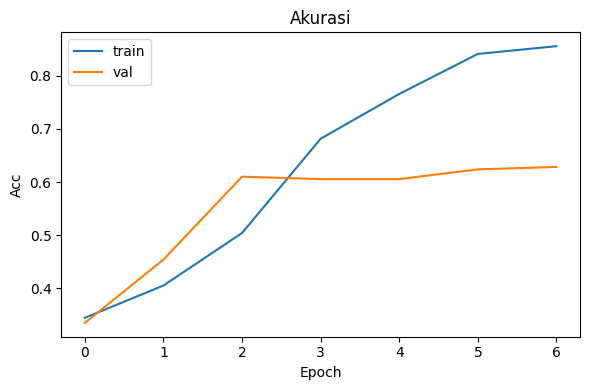

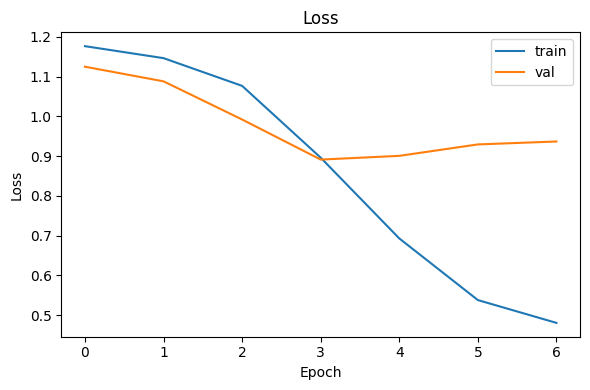

In [112]:
# Kurva sederhana
plt.figure(figsize=(6,4)); plt.plot(hist.history["accuracy"], label="train"); plt.plot(hist.history["val_accuracy"], label="val")
plt.title("Akurasi"); plt.xlabel("Epoch"); plt.ylabel("Acc"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(hist.history["loss"], label="train"); plt.plot(hist.history["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

In [114]:
y_prob = model_bilstm.predict(Xte_pad, batch_size=64)
y_pred = y_prob.argmax(1)

print("[Test] Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("[Test] Macro-F1:", round(f1_score(y_test, y_pred, average="macro"), 4))
print("\nClassification Report (test):\n",
      classification_report(y_test, y_pred, target_names=list(le.classes_), digits=4))

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step
[Test] Accuracy : 0.6116
[Test] Macro-F1: 0.6117

Classification Report (test):
               precision    recall  f1-score   support

     negatif     0.6174    0.5966    0.6068       119
      netral     0.6504    0.6612    0.6557       121
     positif     0.5680    0.5772    0.5726       123

    accuracy                         0.6116       363
   macro avg     0.6119    0.6117    0.6117       363
weighted avg     0.6117    0.6116    0.6115       363



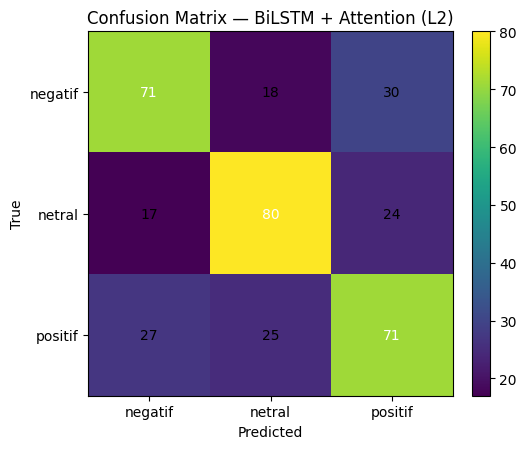

In [115]:
# Confusion matrix
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred)
import matplotlib.pyplot as plt
plt.figure(figsize=(5.6,4.6))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — BiLSTM + Attention (L2)")
plt.xticks(range(len(labels)), labels); plt.yticks(range(len(labels)), labels)
plt.colorbar(im, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]),
                 ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

In [123]:
hist = model_small.fit(
    Xtr_aug, y_tr, validation_data=(Xval_pad, y_val),
    epochs=15, batch_size=32, callbacks=[es, rlr], verbose=1
)

Epoch 1/15


ValueError: Input 0 of layer "functional_7" is incompatible with the layer: expected shape=(None, 48), found shape=(None, 64)

In [128]:
print("BEST val macro-F1:", round(best["f1"], 4))
print("BEST params: max_words=%d, max_len=%d, embed=%d, lstm=%d, dropout=%.2f, lr=%.0e, pos_w=%.2f" %
      best["params"])

BEST val macro-F1: 0.6605
BEST params: max_words=12000, max_len=48, embed=96, lstm=64, dropout=0.50, lr=1e-03, pos_w=1.15


In [129]:
max_words, max_len, embed_dim, lstm_units, drop, lr, pos_w = best["params"]

In [133]:
Xtr_full, Xv_tmp, Xte = make_dataset(X_train_text, X_val_text, X_test_text, max_words, max_len)  # Xv_tmp diabaikan
ytr_full = y_train

vocab_size = min(max_words, len(tok.word_index)+1)
tf.keras.backend.clear_session()

# Bangun ulang model dengan params terbaik
inp = layers.Input(shape=(max_len,), dtype="int32")
emb = layers.Embedding(vocab_size, embed_dim, mask_zero=False,
                       embeddings_regularizer=regularizers.l2(1e-4))(inp)
x   = layers.SpatialDropout1D(0.25)(emb)
seq = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True,
                    dropout=0.30, recurrent_dropout=0.30,
                    kernel_regularizer=regularizers.l2(1e-4),
                    recurrent_regularizer=regularizers.l2(1e-4))
      )(x)
score = layers.TimeDistributed(layers.Dense(1, activation="tanh"))(seq)
mask  = layers.Lambda(lambda t: tf.cast(tf.not_equal(t, 0), tf.float32))(inp)
mask  = layers.Lambda(lambda t: tf.expand_dims(t, -1))(mask)
neg_inf_pad = layers.Lambda(lambda m: (1.0 - m) * -1e9)(mask)
score_m = layers.Add()([score, neg_inf_pad])
weights = layers.Softmax(axis=1)(score_m)
ctx = layers.Multiply()([seq, weights])
ctx = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(ctx)
h   = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(ctx)
h   = layers.Dropout(drop)(h)
out = layers.Dense(len(le.classes_), activation="softmax")(h)

final_model = models.Model(inp, out)
opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
final_model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
es  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-5, verbose=1)


In [134]:
cw = {i:1.0 for i in range(len(le.classes_))}
if "positif" in le.classes_:
    cls_pos = int(np.where(le.classes_=="positif")[0][0])
    cw[cls_pos] = pos_w

In [143]:
hist = final_model.fit(
    Xtr_full, ytr_full,
    validation_split=0.15,
    epochs=14, batch_size=32,
    class_weight=cw,
    verbose=1
)

Epoch 1/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8566 - loss: 0.4967 - val_accuracy: 0.5872 - val_loss: 0.9852
Epoch 2/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8687 - loss: 0.4942 - val_accuracy: 0.5826 - val_loss: 0.9861
Epoch 3/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.8630 - loss: 0.4838 - val_accuracy: 0.5872 - val_loss: 0.9897
Epoch 4/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8606 - loss: 0.4959 - val_accuracy: 0.5826 - val_loss: 0.9904
Epoch 5/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8517 - loss: 0.4851 - val_accuracy: 0.5872 - val_loss: 0.9914
Epoch 6/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.8647 - loss: 0.5071 - val_accuracy: 0.5872 - val_loss: 0.9930
Epoch 7/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8679 - loss: 0.4776 - val_accuracy: 0.5826 - val_loss: 0.9942
Epoch 8/14
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8703 - loss: 0.4719 - val_accuracy: 0.

In [144]:
y_prob = final_model.predict(Xte, verbose=0)
y_pred = y_prob.argmax(1)
print("\n[Test] Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("[Test] macro-F1:", round(f1_score(y_test, y_pred, average="macro"), 4))
print("\nClassification Report (test):\n",
      classification_report(y_test, y_pred, target_names=list(le.classes_), digits=4))


[Test] Accuracy: 0.5702
[Test] macro-F1: 0.57

Classification Report (test):
               precision    recall  f1-score   support

     negatif     0.5462    0.5966    0.5703       119
      netral     0.5625    0.5950    0.5783       121
     positif     0.6095    0.5203    0.5614       123

    accuracy                         0.5702       363
   macro avg     0.5727    0.5707    0.5700       363
weighted avg     0.5731    0.5702    0.5700       363



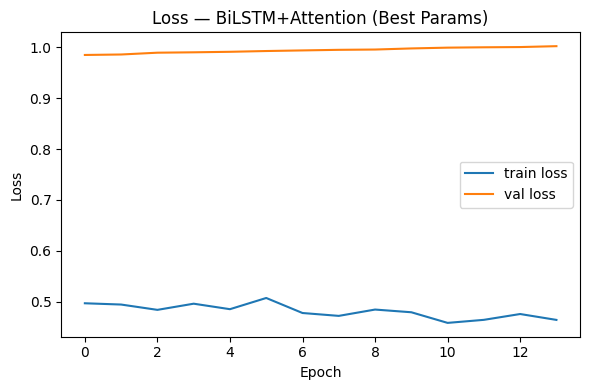

In [145]:
plt.figure(figsize=(6,4))
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.title("Loss — BiLSTM+Attention (Best Params)")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.tight_layout(); plt.show()


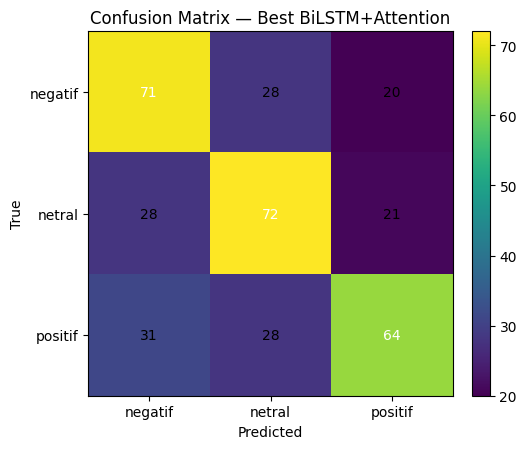

In [146]:
labels = list(le.classes_)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5.6,4.6))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix — Best BiLSTM+Attention")
plt.xticks(range(len(labels)), labels); plt.yticks(range(len(labels)), labels)
plt.colorbar(im, fraction=0.046, pad=0.04)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i,j]),
                 ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()